In this notebook we want to examine the effects of T1236C, T2677G and T3435C on local and global translation rates. 

- We check their effects on measures correlated with translation speed like MFE, CAI/FPTC and tAI.
- We check whether they are on possible translation bottle necks. 


In [16]:
import pandas as pd
import numpy as np 
from Utils_MDR1 import variant_info, mutate_cds_sequence, calc_windows_mfe, calc_mfe_per_position, SynonymousCodons, tissues_titles_dict
import matplotlib.pyplot as plt
import re
from typing import Union
import seaborn as sns
import matplotlib as mpl
import RNA


## Functions

In [58]:
''' 

Returns a list of CAI scores for all codons of a given sequence.
nt_CDS is the sequence, in nucleotides.
cai_dict is a dictionary where the keys are codons and the values are the CAI weights. 

'''

def get_cai_of_sequence(nt_CDS: str, cai_dict: dict) -> list: 
    cai_of_seq = []
    for index in range(0,len(nt_CDS),3):
        codon = nt_CDS[index:index+3]
        cai_val = cai_dict[codon]
        cai_of_seq.append(cai_val)
    return(cai_of_seq)

In [59]:
'''
Returns the estimated decoding rates of codons of a given sequence. Decoding rates are proportional to the MFE.
'''

def get_decoding_rates_from_seq_tasep(seq: str, alpha: float) -> np.array:
    
    mfe_windows = calc_windows_mfe(seq, 39) #calculate mfe per window
    mfe_positions = calc_mfe_per_position(mfe_windows, 'original', 38, 39) #change to mfe per position

    reshaped_arr = mfe_positions.reshape(-1, 3)
    mfe_codons = reshaped_arr.mean(axis=1) #the mfe of a codon is the avrage of the MFE
    # of its three nucleotide positions
    decoding_time_codons = np.exp(-alpha* mfe_codons)

    decoding_rate_codons = 1 / decoding_time_codons
    
    return(decoding_rate_codons)

In [60]:
'''
Prints the local secondary structure of the mRNA in the vicinity of a variant, for the reference and mutated sequences
'''

def info_for_secondary_struct_plot(nt_CDS: str, cds_position: int, change_to: str, margin: int):
    
    ref = nt_CDS[cds_position - margin - 1: cds_position + margin]
    nt_CDS_mut = mutate_cds_sequence(nt_CDS, cds_position, change_to) #mutate the sequence
    mut = nt_CDS_mut[cds_position - margin - 1: cds_position + margin]
    
    (second_struct, _) = RNA.fold(ref)
    (second_struct_mut, _) = RNA.fold(mut)
    
    print("REF:")
    print(ref)
    print(second_struct)
    print("MUT:")
    print(mut)
    print(second_struct_mut)



In [61]:
''' 

Plots and saves the MFE profiles of the original and mutated MDR1 CDS in the vicinity of a variant
"cds_pos_1base" - the positions of the mutations, relative to the CDS, 1-based. 
"mfe_positions" - the vector of mfe scores of the entire CDS. Each CDS position has one score. 
"mfe_positions_mutated" - same, but with the variant in "cds_pos_1base". 
"changed_from" - the original nucleotide in "cds_pos_1base"
"changed_to" - the nucleotide that is in "cds_pos_1base" after the variation. 
"pval" - in the notebook "p_vals_mfe.ipynb" we create randomomized sequences (the MDR1 CDS sequence with a single mutation), calculated the delta-mfe for the randomizations 
and obtained an empirical p-value. Here we retrieve it fore the plot. 

'''

def plot_mfe_change(cds_pos_1base: int, mfe_positions: np.array, mfe_positions_mutated: np.array, changed_from: str, changed_to: str, pval: float) -> None:
    
    plt.figure(figsize=(10, 6))

    x = np.arange(mfe_positions.shape[1]) + 1
    plt.plot(x, mfe_positions.T, label = f'{cds_pos_1base}:{changed_from}', c = 'slategrey')
    plt.plot(x, mfe_positions_mutated.T, label = f'{cds_pos_1base}:{changed_to}', c = 'red')
    delta = np.round((mfe_positions_mutated[0,cds_pos_1base - 1] - mfe_positions[0,cds_pos_1base - 1]),2)

    variant = f"{changed_from}{cds_pos_1base}{changed_to}"
    #plt.title(f"Effect of {variant} on the local MFE profile (delta = {delta}, p = {pval})")
    plt.title(f"{variant} (Delta = {delta}, p = {pval})", size=15)

    plt.xlabel("CDS Position [nt]", size=15)
    plt.ylabel("MFE [kcal/mol]", size=15)
    plt.axvline(x = cds_pos_1base, color = 'royalblue', label = 'position of mutation')
    plt.scatter(cds_pos_1base, mfe_positions.T[cds_pos_1base - 1], c = "slategrey", s = 15 )
    plt.scatter(cds_pos_1base, mfe_positions_mutated.T[cds_pos_1base - 1], c = "red", s = 15)

    plt.text(cds_pos_1base + 1, mfe_positions_mutated.T[cds_pos_1base - 1] , np.round(mfe_positions_mutated[0,cds_pos_1base - 1],2), size=13)
    plt.text(cds_pos_1base - 9, mfe_positions.T[cds_pos_1base - 1], np.round(mfe_positions[0,cds_pos_1base - 1],2), size=13)
    plt.xticks(fontsize=13)
    plt.yticks(fontsize=13)

    plt.legend(prop={'size': 12})
    x_min = cds_pos_1base - 50
    x_max = cds_pos_1base + 50

    plt.xlim([x_min,x_max])
    plt.savefig(f'../Figures/MFE/delta_mfe_{changed_from}{cds_pos_1base}{changed_to}_new_colors.png', bbox_inches = "tight", dpi=500)

    plt.show()


In [62]:
'''

Plots and saves the CAI/FPTC/tAI profiles of the original and the mutated MDR1 CDS in the vicinity of a variant.
"variant" - the name of the variant, for example "T1236C".
"measure" - either CAI, FPTC, tAI
"len_aa" - the length of the protein
"scores_of_cds" - a vector with the scores of the entire CDS (a single score for each aa/codon) 
"measure_dict" - keys are codons, values are the scores of the codons, which depend on the measure
"aa_position" - protein position of the variant (1-based)
"cds_position" - cds position of the variant (1-based)
"tissue" - tAI is tissue specific, we have a different measure_dict for each tissue. 

'''

def plot_cub_change(variant: str, measure: str, len_aa: int, scores_of_cds: list, measure_dict: dict, aa_position: int, cds_position: int,
                    codon_before: str, codon_after: str, change_from: str, change_to: str, pval: float, tissue: str = None, 
                    tissues_titles_dict = None) -> None:
    
    plt.figure(figsize=(10, 6))
    #ploting the scores of the codons in the vicinity of the variant
    plt.scatter(np.arange(1, len_aa + 1), scores_of_cds, c = 'gainsboro', label = 'surroundings', marker = "X", s = 100) 
    plt.axvline(x = aa_position, color = 'royalblue', label = 'position of variant')

    #ploting the scores of the codon in the variant location, before and after the variant
    plt.scatter(aa_position, measure_dict[codon_before], label = f'{cds_position}:{change_from} (codon: {codon_before})', c = "slategrey", marker = "X", s = 100)
    plt.scatter(aa_position, measure_dict[codon_after], label = f'{cds_position}:{change_to} (codon: {codon_after})', c = "red", marker = "X", s = 100)

    plt.text(aa_position + 0.15, measure_dict[codon_before] , np.round(measure_dict[codon_before],2), size=13) #annotations
    plt.text(aa_position + 0.15, measure_dict[codon_after] , np.round(measure_dict[codon_after],2), size=13) #annotations
    plt.xlim([aa_position - 7, aa_position + 7])
    plt.legend(prop={'size': 12})

    delta = np.round(measure_dict[codon_after] - measure_dict[codon_before], 2) #calculate the difference in CUB caused by the variant

    if tissues_titles_dict:
        title = f"{change_from}{cds_position}{change_to}, {tissues_titles_dict[tissue]} (Delta = {delta} , p = {pval})"
    else:
        title = f"{change_from}{cds_position}{change_to} (Delta = {delta} , p = {pval})"
    plt.title(title, size=15)

    plt.xlabel("Protein Position [AA]", size=15)
    plt.ylabel(measure, size=15)
    plt.xticks(fontsize=13)
    plt.yticks(fontsize=13)

    
    save_path = f'../Figures/{measure}/{variant}_delta_{measure}_{tissues_titles_dict[tissue]}.png'if tissue else f'../Figures/{measure}/{variant}_delta_{measure}.png'
    plt.savefig(save_path, bbox_inches = "tight", dpi=500)


In [63]:
''' 
Returns a list of tAI scores for all codons of a given sequence.
nt_CDS is the sequence, in nucleotides.
tai_dict is a dictionary where the keys are codons and the values are the tAI weights. 
'''

def get_tai_of_sequence(nt_CDS: str, tai_dict: dict) -> list:
    tai_of_seq = []
    for index in range(0,len(nt_CDS),3):
        codon = nt_CDS[index:index+3]
        tai_val = tai_dict[codon]
        tai_of_seq.append(tai_val)
    return(tai_of_seq)

In [15]:
''' 
Changes the format of the FTPC data to be more convinent
'''
def get_codon_and_freq(freq_data_per_codon: str) -> tuple:
    
    codon_and_freuqency = re.search("[A-Z](.*?)\(", freq_data_per_codon)
    codon_and_freuqency = codon_and_freuqency[0][:-1].split(" ")
    codons = codon_and_freuqency[0]
    freq1000 = codon_and_freuqency[-1]
    
    return(codons, freq1000)


In [64]:
''' 
Returns a list of FPTC (frequency per thousand codons) scores for all codons of a given sequence.
nt_CDS is the sequence, in nucleotides.
fptc_dict is a dictionary where the keys are codons and the values are the fptc weights. 
'''

def get_fptc_of_sequence(nt_CDS: str, fptc_dict: dict) -> list:
    
    fptc_of_seq = []
    for index in range(0,len(nt_CDS),3):
        codon = nt_CDS[index:index+3]
        freq1000_val = fptc_dict[codon]
        fptc_of_seq.append(freq1000_val)
    return(fptc_of_seq)   

## Main

In [3]:
''' Get the MDR1 coding region sequence '''
gene = "ENSG00000085563" #MDR1
genes_dict = pd.read_pickle(f"../Data/cdna_{gene}.pickle.gz")
nt_CDS = genes_dict['data'][0]['homologies'][0]['source']['seq'][:-3] #removing stop codon -> msa was on aas and ttanslated back, 
#so no info on stop codons

''' Get/define variables needed for measures calculations (CAI, FPTC, tAI...), not specific to any variant '''
#CAI
codon_usage_dict = pd.read_pickle("../Data/homo_sapiens_CAI.pickle") # get human CAI weights
cai_of_cds = get_cai_of_sequence(nt_CDS, codon_usage_dict) #calculate the CAI weights for the complete MDR1 CDS
len_aa = len(cai_of_cds) #length of the *protein*
#tAI
tai_tissues = pd.read_pickle("../Data/tAI_human_tissue_specific.pickle")# get human tAI weights- this is a nested dictionary, 
#tAI changes dramatically among tissues
tissues_mdr1 = ["KIRC", "LIHC", "GBM_", "COAD"] #tissues in organs where MDR1 is naturally highly expressed
#FPTC - frequency per thousand codons
codon_usage_csv = pd.read_csv("../Data/Human_codon_frequency.txt", skiprows = 5, header = None) # get human FPTC weights
codons_and_freq1000 =  codon_usage_csv[0].apply(lambda x: get_codon_and_freq(x))
dict_freq1000 = dict((codon.replace("U","T"), float(freq)) for codon, freq in codons_and_freq1000)


## Obtain data for to run TASEP (Figure 5 in the main paper). Note that the code that actually runs the TASEP is in MATLAB. 

In [ ]:
''' Get MFE profiles for the REF and variant sequences, to calculate the decoding rates for TASEP '''

#ref
nt_CDS = genes_dict['data'][0]['homologies'][0]['source']['seq'][:-3] #get cds sequence and remove stop codon
mfe_windows = calc_windows_mfe(nt_CDS, 39) #calculate mfe per window
mfe_positions = calc_mfe_per_position(mfe_windows, 'original', 38, 39) #change to mfe per position
np.savetxt(f'../Data/TASEP/MFE_REF.txt', mfe_positions, delimiter=',') #save mfe profile to a text file

# T1236C 
cds_position = 1236
change_to = "C"
mut_seq = mutate_cds_sequence(nt_CDS, cds_position, change_to) #mutate the sequence
mfe_windows = calc_windows_mfe(mut_seq, 39) #calculate mfe per window
mfe_positions = calc_mfe_per_position(mfe_windows, 'original', 38, 39) #change to mfe per position
np.savetxt(f'../Data/TASEP/MFE_T1236C.txt', mfe_positions, delimiter=',')#save mfe profile to a text file

# T2677G
cds_position = 2677
change_to = "G"
mut_seq = mutate_cds_sequence(nt_CDS, cds_position, change_to) #mutate the sequence
mfe_windows = calc_windows_mfe(mut_seq, 39) #calculate mfe per window
mfe_positions = calc_mfe_per_position(mfe_windows, 'original', 38, 39) #change to mfe per position
np.savetxt(f'../Data/TASEP/MFE_T2677G.txt', mfe_positions, delimiter=',')#save mfe profile to a text file

# T1236C 
cds_position = 3435
change_to = "C"
mut_seq = mutate_cds_sequence(nt_CDS, cds_position, change_to) #mutate the sequence
mfe_windows = calc_windows_mfe(mut_seq, 39) #calculate mfe per window
mfe_positions = calc_mfe_per_position(mfe_windows, 'original', 38, 39) #change to mfe per position
np.savetxt(f'../Data/TASEP/MFE_T3435C.txt', mfe_positions, delimiter=',')#save mfe profile to a text file


In [ ]:
''' Assess codon decoding rate for TASEP model '''

num_codons_per_site = 1
alpha = 0.1 # lambda = exp^(alpha*MFE)

''' Reference sequence '''
name = "REF"
nt_CDS = genes_dict['data'][0]['homologies'][0]['source']['seq'][:-3] #remove stop codon
decoding_rate_sites = get_decoding_rates_from_seq_tasep(nt_CDS, alpha)
np.savetxt(f'../Data/TASEP/decoding_rates_MDR1_{name}_{alpha}alpha.txt', decoding_rate_sites, delimiter=',')

''' T1236C '''
name = "T1236C"
cds_position = 1236
change_to = "C"
mut_t1236c = mutate_cds_sequence(nt_CDS, cds_position, change_to) #mutate the sequence
decoding_rate_sites = get_decoding_rates_from_seq_tasep(mut_t1236c, alpha)
np.savetxt(f'../Data/TASEP/decoding_rates_MDR1_{name}_{alpha}alpha.txt', decoding_rate_sites, delimiter=',')

''' T2677G '''
name = "T2677G"
cds_position = 2677
change_to = "G"
mut_t2677g = mutate_cds_sequence(nt_CDS, cds_position, change_to) #mutate the sequence
decoding_rate_sites = get_decoding_rates_from_seq_tasep(mut_t2677g, alpha)
np.savetxt(f'../Data/TASEP/decoding_rates_MDR1_{name}_{alpha}alpha.txt', decoding_rate_sites, delimiter=',')

''' T3435C '''
name = "T3435C"
cds_position = 3435
change_to = "C"
mut_t3435c = mutate_cds_sequence(nt_CDS, cds_position, change_to) #mutate the sequence
decoding_rate_sites = get_decoding_rates_from_seq_tasep(mut_t3435c, alpha)
np.savetxt(f'../Data/TASEP/decoding_rates_MDR1_{name}_{alpha}alpha.txt', decoding_rate_sites, delimiter=',')

''' T1236C_T2677G '''
name = "T1236C_T2677G"
cds_position = 2677
change_to = "G"
mut_t1236c_t2677g = mutate_cds_sequence(mut_t1236c, cds_position, change_to) #mutate the sequence
decoding_rate_sites = get_decoding_rates_from_seq_tasep(mut_t1236c_t2677g, alpha)
np.savetxt(f'../Data/TASEP/decoding_rates_MDR1_{name}_{alpha}alpha.txt', decoding_rate_sites, delimiter=',')

''' T1236C_T3435C ''' 
name = "T1236C_T3435C"
cds_position = 3435
change_to = "C"
mut_t1236c_t3435c = mutate_cds_sequence(mut_t1236c, cds_position, change_to) #mutate the sequence
decoding_rate_sites = get_decoding_rates_from_seq_tasep(mut_t1236c_t3435c, alpha)
np.savetxt(f'../Data/TASEP/decoding_rates_MDR1_{name}_{alpha}alpha.txt', decoding_rate_sites, delimiter=',')

''' T2677G_T3435C ''' 
name = "T2677G_T3435C"
cds_position = 3435
change_to = "C"
mut_t2677g_t3435c = mutate_cds_sequence(mut_t2677g, cds_position, change_to) #mutate the sequence
decoding_rate_sites = get_decoding_rates_from_seq_tasep(mut_t2677g_t3435c, alpha)
np.savetxt(f'../Data/TASEP/decoding_rates_MDR1_{name}_{alpha}alpha.txt', decoding_rate_sites, delimiter=',')

''' T1236C_T2677G_T3435C '''
name = "T1236C_T2677G_T3435C"
cds_position = 3435
change_to = "C"
mut_t1236c_t2677g_t3435c = mutate_cds_sequence(mut_t1236c_t2677g, cds_position, change_to) #mutate the sequence
decoding_rate_sites = get_decoding_rates_from_seq_tasep(mut_t1236c_t2677g_t3435c, alpha)
np.savetxt(f'../Data/TASEP/decoding_rates_MDR1_{name}_{alpha}alpha.txt', decoding_rate_sites, delimiter=',')


## T1236C

In [39]:
''' Get variant info '''

mut_num = 1
variant_name = variant_info[mut_num]["variant_name"]
aa_position = variant_info[mut_num]["aa_position"]
cds_position = variant_info[mut_num]["cds_position"]
codon_before = variant_info[mut_num]["codon_before"]
codon_after = variant_info[mut_num]["codon_after"]
change_from = variant_info[mut_num]["change_from"]
change_to = variant_info[mut_num]["change_to"]


In [20]:
''' 
Get information for secondary structure plot - will later be ploted with forna 
(http://rna.tbi.univie.ac.at/forna/) - Figure 2 in the main paper 
'''

margin = 20
info_for_secondary_struct_plot(nt_CDS, cds_position, change_to, margin)

REF:
GAAGTTAAGATCTTGAAGGGTCTGAACCTGAAGGTGCAGAG
...(((.((((((....)))))).)))(((......)))..
MUT:
GAAGTTAAGATCTTGAAGGGCCTGAACCTGAAGGTGCAGAG
.................(.((((........)))).)....


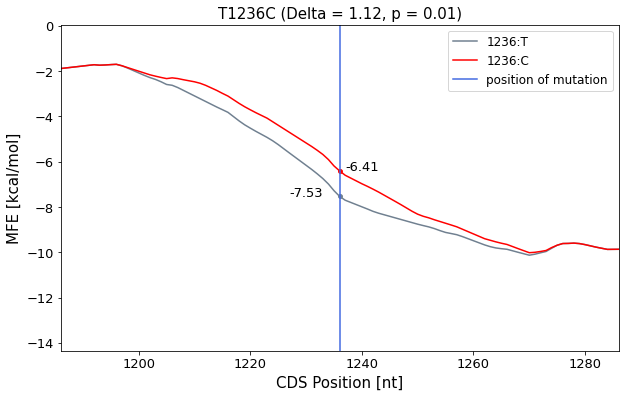

In [23]:
''' Plot mfe profiles - Figure 2 in the main paper '''
measure = "mfe"

#get mfe profile of the original sequence
mfe_windows = calc_windows_mfe(nt_CDS, 39) #calculate mfe per window
mfe_positions = calc_mfe_per_position(mfe_windows, 'original', 38, 39) #change to mfe per position

#get mfe profile of the mutated sequence
nt_CDS_mut = mutate_cds_sequence(nt_CDS, cds_position, change_to) #mutate the sequence
mfe_windows_mut = calc_windows_mfe(nt_CDS_mut, 39) #calculate mfe per window
mfe_positions_mut = calc_mfe_per_position(mfe_windows_mut, 'original', 38, 39) #change to mfe per position

#we also calculated a p-value in the notebook "p_vals_mfe.ipynb"
pvalue = pd.read_pickle(f"../Results/{measure}/delta_{measure}/pval_{change_from}{cds_position}{change_to}.pickle")

#plot both
plot_mfe_change(cds_position, mfe_positions, mfe_positions_mut, change_from, change_to, np.round(pvalue,2))


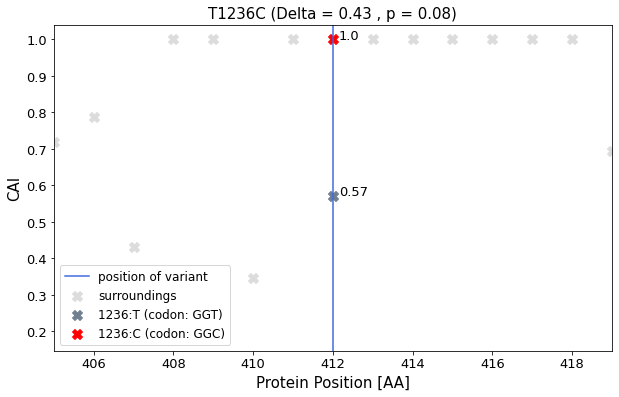

In [27]:
''' Plot CAI change - figure 3 in the main paper '''

measure = "CAI"
pval = np.round(pd.read_pickle(f"../Results/{measure}/delta_{measure}/pval_{cds_position}.pickle"),2) 
#pvals were calculated in p_vals_CUB_MDR1.ipynb

plot_cub_change(variant_name, measure, len_aa, cai_of_cds, codon_usage_dict, aa_position, cds_position, codon_before, codon_after, 
                change_from, change_to, pval)


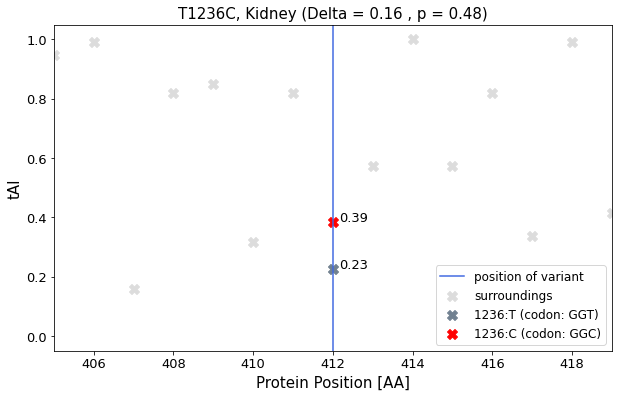

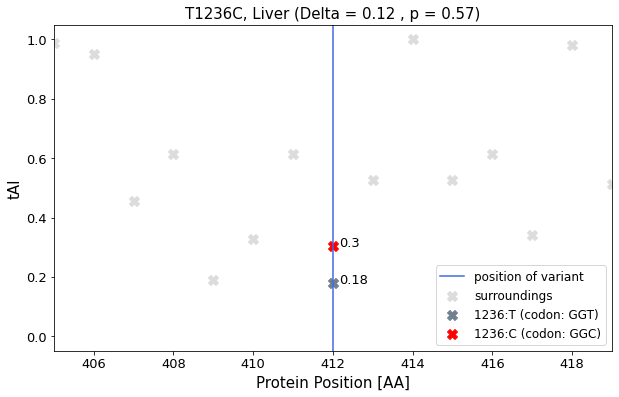

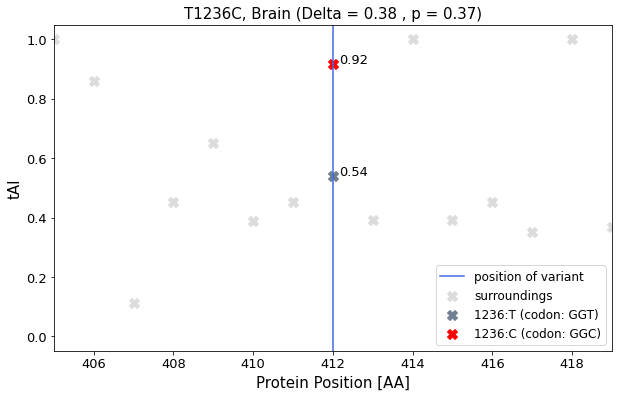

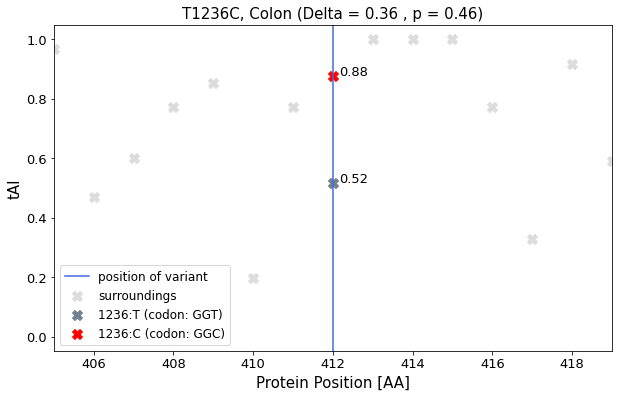

In [37]:
''' Plot tAI change - figure 4 in the main paper '''
measure = "tAI"

for tissue in tissues_mdr1:
    tai_of_cds= get_tai_of_sequence(nt_CDS, tai_tissues[tissue])
    pval = np.round(pd.read_pickle(f"../Results/{measure}/delta_{measure}/{tissue}/pval_{cds_position}.pickle"),2) #calculated in "p_vals_CUB_MDR1.ipynb"
    plot_cub_change(variant_name, measure, len_aa, tai_of_cds, tai_tissues[tissue], aa_position, cds_position, codon_before, codon_after, change_from, change_to, pval, tissue, tissues_titles_dict)
    

### T3435C

In [41]:
''' Get variant info '''

mut_num = 3
variant_name = variant_info[mut_num]["variant_name"]
aa_position = variant_info[mut_num]["aa_position"]
cds_position = variant_info[mut_num]["cds_position"]
codon_before = variant_info[mut_num]["codon_before"]
codon_after = variant_info[mut_num]["codon_after"]
change_from = variant_info[mut_num]["change_from"]
change_to = variant_info[mut_num]["change_to"]


In [42]:
''' 
Get information for secondary structure plot - will later be ploted with forna 
(http://rna.tbi.univie.ac.at/forna/) - Figure 2 in the main paper 
'''

margin = 20
info_for_secondary_struct_plot(nt_CDS, cds_position, change_to, margin)

REF:
GTGGTGTCACAGGAAGAGATTGTGAGGGCAGCAAAGGAGGC
.((.(.((((((.......)))))).).))...........
MUT:
GTGGTGTCACAGGAAGAGATCGTGAGGGCAGCAAAGGAGGC
.((.((((.((.((.....)).))..)))).))........


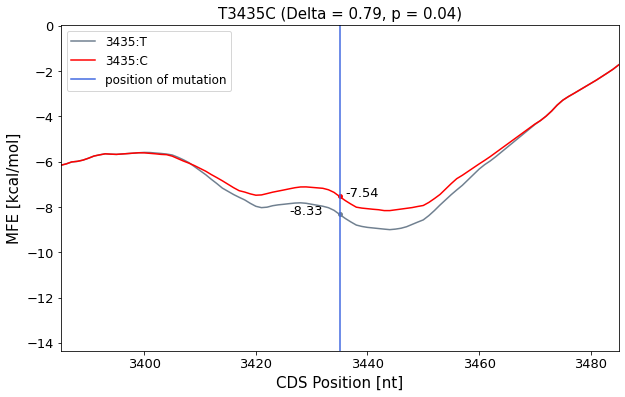

In [43]:
''' Plot mfe profiles - Figure 2 in the main paper '''
measure = "mfe"

#get mfe profile of the original sequence
mfe_windows = calc_windows_mfe(nt_CDS, 39) #calculate mfe per window
mfe_positions = calc_mfe_per_position(mfe_windows, 'original', 38, 39) #change to mfe per position

#get mfe profile of the mutated sequence
nt_CDS_mut = mutate_cds_sequence(nt_CDS, cds_position, change_to) #mutate the sequence
mfe_windows_mut = calc_windows_mfe(nt_CDS_mut, 39) #calculate mfe per window
mfe_positions_mut = calc_mfe_per_position(mfe_windows_mut, 'original', 38, 39) #change to mfe per position

#we also calculated a p-value in the notebook "p_vals_mfe.ipynb"
pvalue = pd.read_pickle(f"../Results/{measure}/delta_{measure}/pval_{change_from}{cds_position}{change_to}.pickle")

#plot both
plot_mfe_change(cds_position, mfe_positions, mfe_positions_mut, change_from, change_to, np.round(pvalue,2))


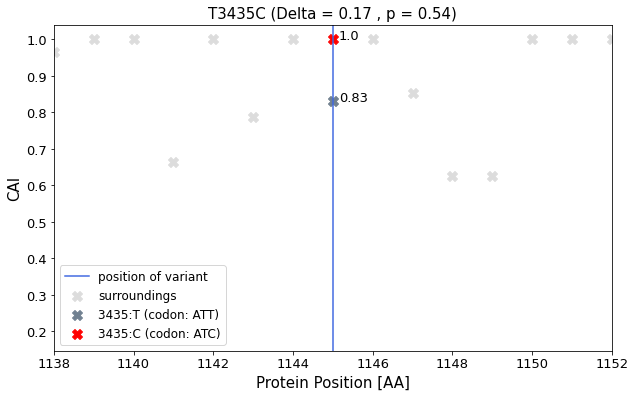

In [44]:
''' Plot CAI change - figure 3 in the main paper '''

measure = "CAI"
pval = np.round(pd.read_pickle(f"../Results/{measure}/delta_{measure}/pval_{cds_position}.pickle"),2) 
#pvals were calculated in p_vals_CUB_MDR1.ipynb

plot_cub_change(variant_name, measure, len_aa, cai_of_cds, codon_usage_dict, aa_position, cds_position, codon_before, codon_after, 
                change_from, change_to, pval)


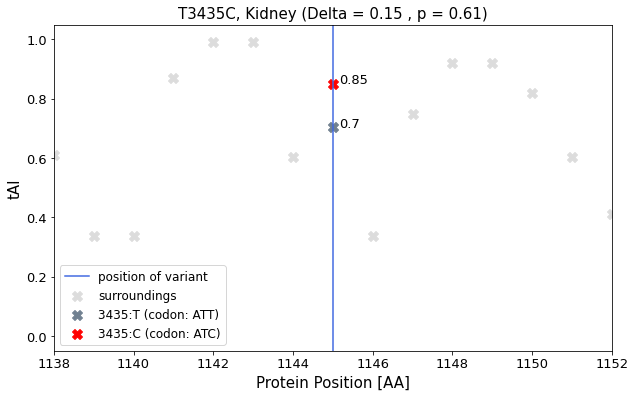

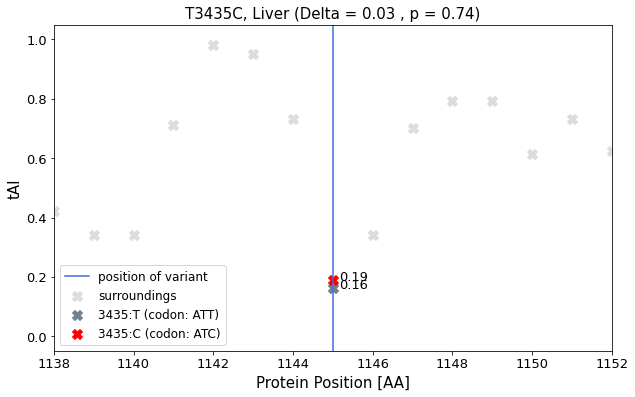

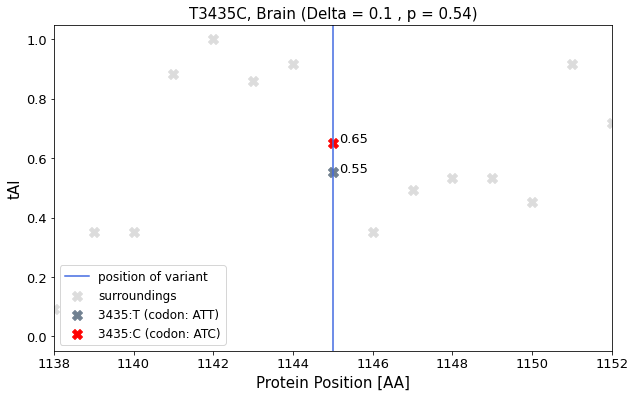

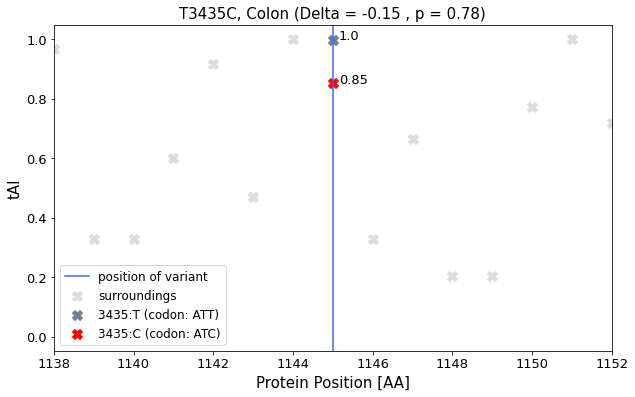

In [45]:
''' Plot tAI change - figure 4 in the main paper '''
measure = "tAI"

for tissue in tissues_mdr1:
    tai_of_cds= get_tai_of_sequence(nt_CDS, tai_tissues[tissue])
    pval = np.round(pd.read_pickle(f"../Results/{measure}/delta_{measure}/{tissue}/pval_{cds_position}.pickle"),2) #calculated in "p_vals_CUB_MDR1.ipynb"
    plot_cub_change(variant_name, measure, len_aa, tai_of_cds, tai_tissues[tissue], aa_position, cds_position, codon_before, codon_after, change_from, change_to, pval, tissue, tissues_titles_dict)
    

### T2677G

In [47]:
''' Get variant info '''

mut_num = 2
variant_name = variant_info[mut_num]["variant_name"]
aa_position = variant_info[mut_num]["aa_position"]
cds_position = variant_info[mut_num]["cds_position"]
codon_before = variant_info[mut_num]["codon_before"]
codon_after = variant_info[mut_num]["codon_after"]
change_from = variant_info[mut_num]["change_from"]
change_to = variant_info[mut_num]["change_to"]


In [48]:
''' 
Get information for secondary structure plot - will later be ploted with forna 
(http://rna.tbi.univie.ac.at/forna/) - Figure 2 in the main paper 
'''

margin = 20
info_for_secondary_struct_plot(nt_CDS, cds_position, change_to, margin)

REF:
ATAAGAAAGAACTAGAAGGTTCTGGGAAGATCGCTACTGAA
.......((((((....))))))..................
MUT:
ATAAGAAAGAACTAGAAGGTGCTGGGAAGATCGCTACTGAA
............(((.(((..((....))..).)).)))..


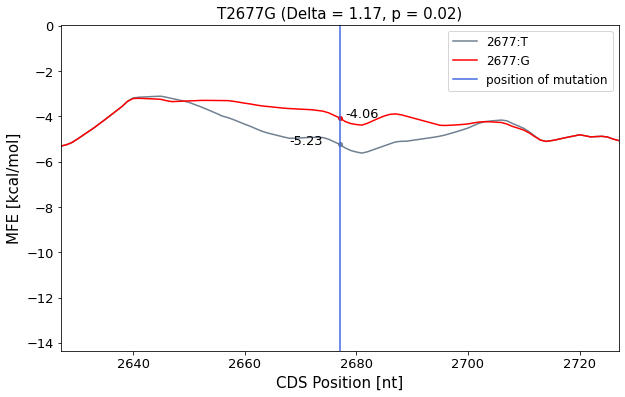

In [49]:
''' Plot mfe profiles - Figure 2 in the main paper '''
measure = "mfe"

#get mfe profile of the original sequence
mfe_windows = calc_windows_mfe(nt_CDS, 39) #calculate mfe per window
mfe_positions = calc_mfe_per_position(mfe_windows, 'original', 38, 39) #change to mfe per position

#get mfe profile of the mutated sequence
nt_CDS_mut = mutate_cds_sequence(nt_CDS, cds_position, change_to) #mutate the sequence
mfe_windows_mut = calc_windows_mfe(nt_CDS_mut, 39) #calculate mfe per window
mfe_positions_mut = calc_mfe_per_position(mfe_windows_mut, 'original', 38, 39) #change to mfe per position

#we also calculated a p-value in the notebook "p_vals_mfe.ipynb"
pvalue = pd.read_pickle(f"../Results/{measure}/delta_{measure}/pval_{change_from}{cds_position}{change_to}.pickle")

#plot both
plot_mfe_change(cds_position, mfe_positions, mfe_positions_mut, change_from, change_to, np.round(pvalue,2))


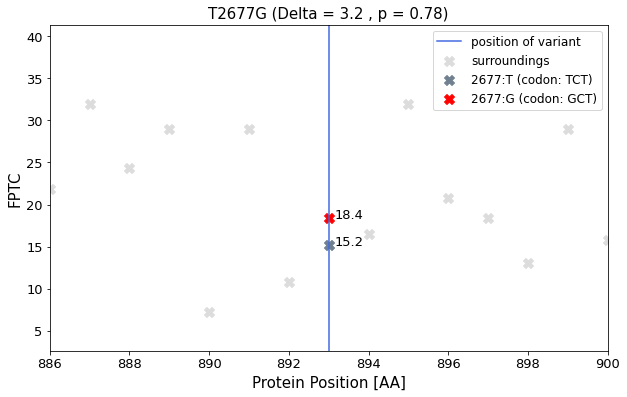

In [51]:
''' Plot CAI change - figure 3 in the main paper '''

measure = "FPTC"
fptc_of_cds = get_fptc_of_sequence(nt_CDS, dict_freq1000)
plot_cub_change(variant_name, measure, len_aa, fptc_of_cds, dict_freq1000, aa_position, cds_position, codon_before, codon_after, change_from, change_to, pval)


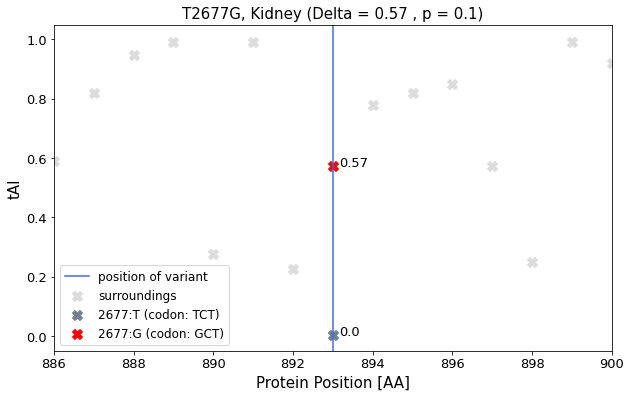

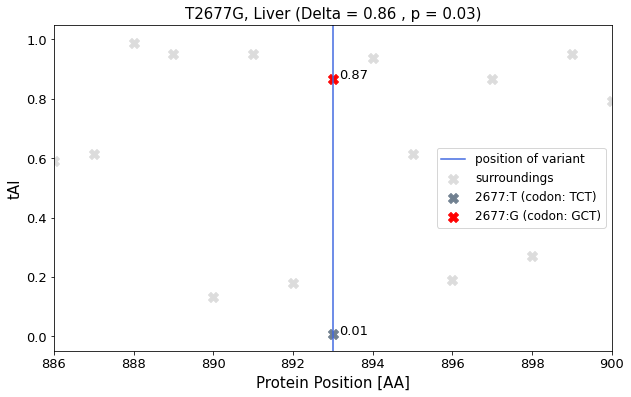

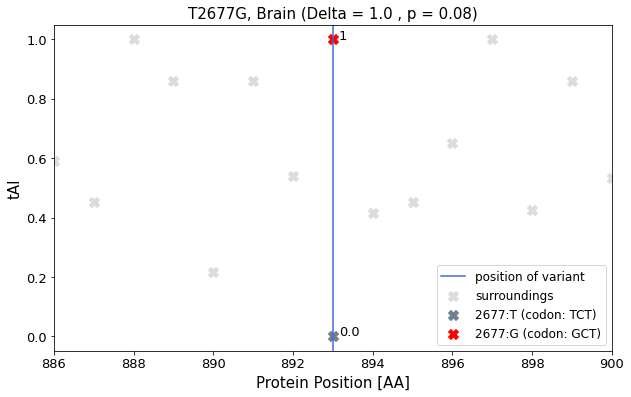

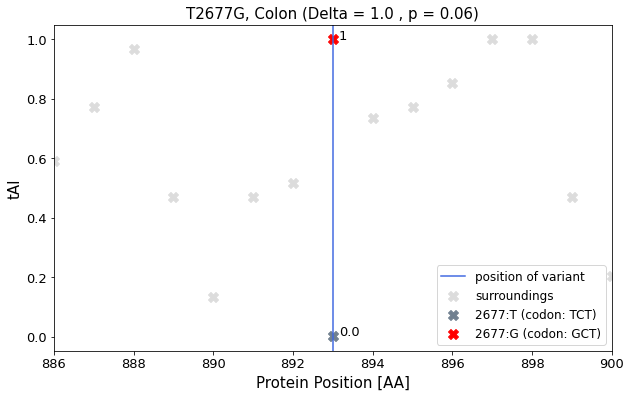

In [52]:
''' Plot tAI change - figure 4 in the main paper '''
measure = "tAI"

for tissue in tissues_mdr1:
    tai_of_cds= get_tai_of_sequence(nt_CDS, tai_tissues[tissue])
    pval = np.round(pd.read_pickle(f"../Results/{measure}/delta_{measure}/{tissue}/pval_{cds_position}.pickle"),2) #calculated in "p_vals_CUB_MDR1.ipynb"
    plot_cub_change(variant_name, measure, len_aa, tai_of_cds, tai_tissues[tissue], aa_position, cds_position, codon_before, codon_after, change_from, change_to, pval, tissue, tissues_titles_dict)
    

## Plots related to the measures that are not variant specific

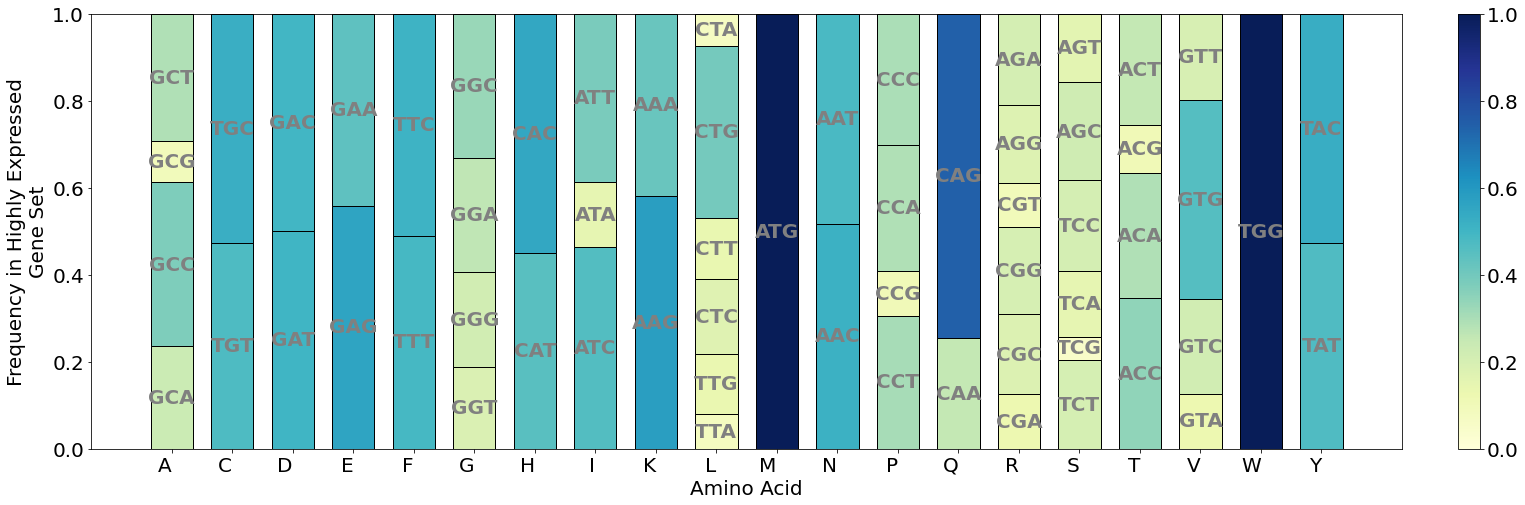

In [53]:
''' Visualize CAI dictionary for human - figure 3d in the main paper '''

cai_df = pd.DataFrame(columns = ["Codon", "Amino Acid", "CAI"]) #initilize df for plot

for amino_acid in SynonymousCodons.keys():
    
    if amino_acid not in ["-", "*"]:
        temp_df = pd.DataFrame(columns = ["Codon", "Amino Acid", "CAI"])
        syn_codons = SynonymousCodons[amino_acid]
        cai_weights = [codon_usage_dict[codon] for codon in syn_codons]

        temp_df["Codon"] = syn_codons
        temp_df["Amino Acid"] = amino_acid
        temp_df["CAI"] = cai_weights

        cai_df = pd.concat([cai_df, temp_df])

# Group by amino acid
amino_acid_groups = cai_df.groupby('Amino Acid')

# Create a single plot
fig, ax = plt.subplots(figsize=(25, 8))

# Initialize the position for each amino acid group
positions = range(len(amino_acid_groups))
bar_width = 0.7

# Loop through each amino acid group and plot the corresponding stacked bars
for pos, (amino_acid, group) in zip(positions, amino_acid_groups):
    syn_codons = group['Codon']
    cai_weights = group['CAI']

    # Normalize the CAI scores so their sum is 1
    total_weight = cai_weights.sum()
    normalized_weights = cai_weights / total_weight

    # Create the stacked bar plot with normalized values
    bottom = 0  # Starting position of the bottom end of the bar
    for codon, weight in zip(syn_codons, normalized_weights):
        ax.bar(pos, weight, bottom=bottom, width=bar_width, color=plt.cm.YlGnBu(weight), edgecolor='black')
        bottom += weight  # Update the bottom position for the next bar

    # Adding codon labels directly on the bars
    bottom = 0
    for codon, weight in zip(syn_codons, normalized_weights):
        ax.text(pos, bottom + weight / 2, codon, ha='center', va='center', color='grey', fontsize=20, fontweight='bold')

        bottom += weight

# Set x-ticks and labels
ax.set_xticks(positions)
ax.set_xticklabels(amino_acid_groups.groups.keys(), ha='right')


# Set limits and labels
ax.set_ylim(0, 1)
ax.set_xlabel('Amino Acid', size = 20)
ax.set_ylabel('Frequency in Highly Expressed\nGene Set', size = 20)

plt.xticks(size = 20)
plt.yticks(size = 20)

# Create a colorbar
norm = mpl.colors.Normalize(vmin=0, vmax=1)
sm = plt.cm.ScalarMappable(cmap='YlGnBu', norm=norm)
sm.set_array([])  # Only needed for older versions of matplotlib
cbar = plt.colorbar(sm, ax=ax, fraction=0.02, pad=0.04)
cbar.ax.tick_params(labelsize=20)  # Adjust the value to your desired font size

save_path = f'../Figures/CAI/CAI_human_visualization.png'
plt.savefig(save_path, dpi=500)

# Show the plot
plt.show()

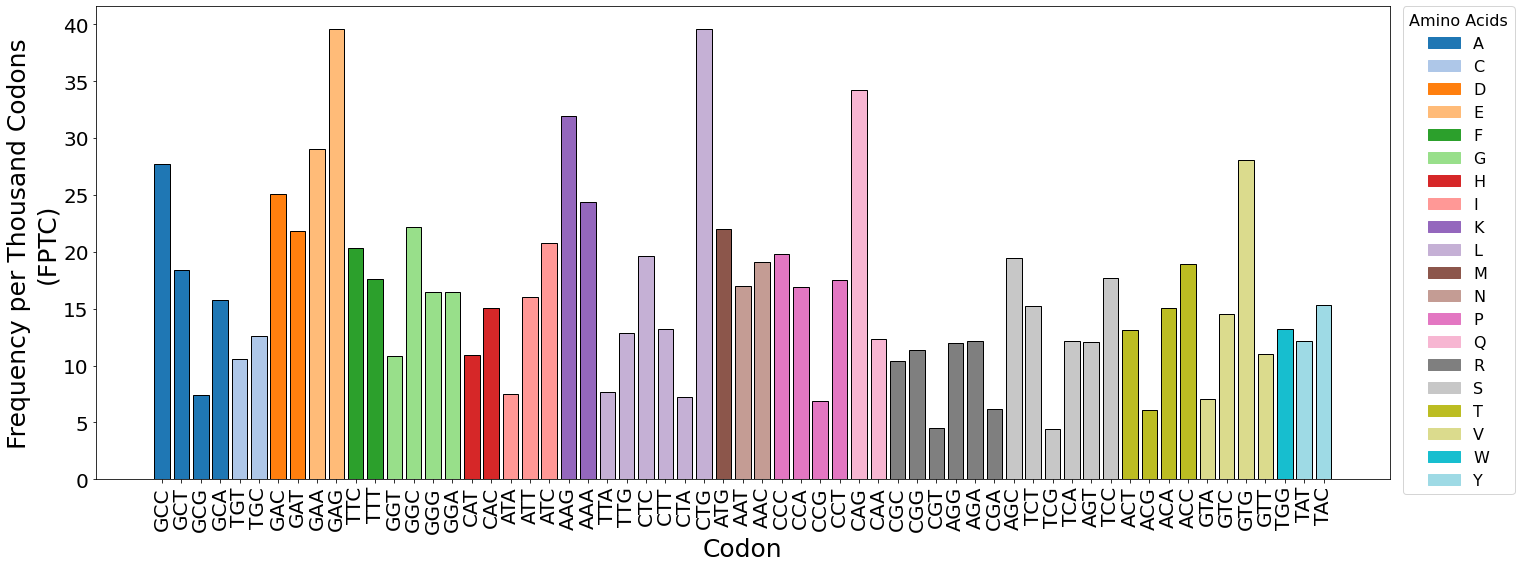

In [54]:
''' Visualize FPTC dictionary for human - figure 3e in the main paper  '''

measure = "FPTC"

ftpc_df = pd.DataFrame(columns = ["Codon", "Amino Acid", "FPTC"]) #initilize df for plot

for amino_acid in SynonymousCodons.keys():
    
    if amino_acid != "-":
    
        temp_df = pd.DataFrame(columns = ["Codon", "Amino Acid", "FPTC"])
        syn_codons = SynonymousCodons[amino_acid]
        ftpc_weights = [dict_freq1000[codon] for codon in syn_codons]

        temp_df["Codon"] = syn_codons
        temp_df["Amino Acid"] = amino_acid
        temp_df["FPTC"] = ftpc_weights

        ftpc_df = pd.concat([ftpc_df, temp_df])

ftpc_df = ftpc_df.sort_values(by='Amino Acid')
ftpc_df = ftpc_df.iloc[3:]

# Generate a color map for Amino Acids
unique_amino_acids = ftpc_df['Amino Acid'].unique()
color_map = {amino_acid: plt.cm.tab20(i / len(unique_amino_acids)) for i, amino_acid in enumerate(unique_amino_acids)}

# Create the bar plot
plt.figure(figsize=(25, 8))
bars = plt.bar(ftpc_df['Codon'], ftpc_df['FPTC'], color=[color_map[aa] for aa in ftpc_df['Amino Acid']], edgecolor='black')

# Add a legend for the amino acids
legend_handles = [plt.Rectangle((0, 0), 1, 1, color=color_map[aa]) for aa in unique_amino_acids]
plt.legend(legend_handles, unique_amino_acids, title="Amino Acids", bbox_to_anchor=(1.01, 1), loc='upper left', borderaxespad=0., fontsize="16", title_fontsize=16)

# Adding labels and title
plt.xticks(rotation=90, size = 20)
plt.yticks(size = 20)

plt.xlabel('Codon', size = 25)
plt.ylabel('Frequency per Thousand Codons\n(FPTC)', size = 25)

plt.tight_layout(rect=[0, 0, 0.85, 1])
save_path = f'../Figures/{measure}/FPTC_human_visualization.png'
plt.savefig(save_path, dpi=500)


# Show the plot
plt.show()

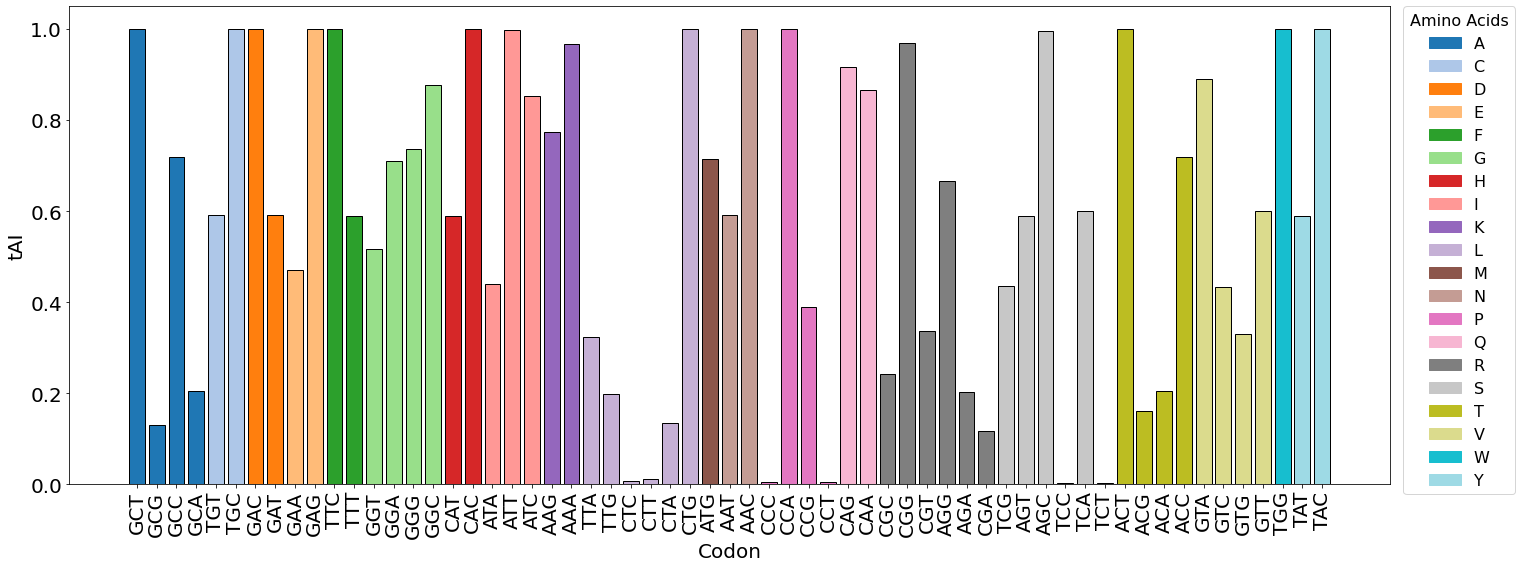

In [55]:
''' Visualize tAI dictionary for human '''

measure = "tAI"

tai_df = pd.DataFrame(columns = ["Codon", "Amino Acid", "tAI"])
dict_tai = tai_tissues["COAD"]

for amino_acid in SynonymousCodons.keys():
    
    if amino_acid not in ["-", "*"]:
    
        temp_df = pd.DataFrame(columns = ["Codon", "Amino Acid", "tAI"])
        syn_codons = SynonymousCodons[amino_acid]
        tai_weights = [dict_tai[codon] for codon in syn_codons]

        temp_df["Codon"] = syn_codons
        temp_df["Amino Acid"] = amino_acid
        temp_df["tAI"] = tai_weights

        tai_df = pd.concat([tai_df, temp_df])
        
tai_df = tai_df.sort_values(by='Amino Acid')
# Generate a color map for Amino Acids
unique_amino_acids = tai_df['Amino Acid'].unique()
color_map = {amino_acid: plt.cm.tab20(i / len(unique_amino_acids)) for i, amino_acid in enumerate(unique_amino_acids)}

# Create the bar plot
plt.figure(figsize=(25, 8))
bars = plt.bar(tai_df['Codon'], tai_df['tAI'], color=[color_map[aa] for aa in tai_df['Amino Acid']], edgecolor='black')

# Add a legend for the amino acids
legend_handles = [plt.Rectangle((0, 0), 1, 1, color=color_map[aa]) for aa in unique_amino_acids]
plt.legend(legend_handles, unique_amino_acids, title="Amino Acids", bbox_to_anchor=(1.01, 1), loc='upper left', borderaxespad=0., fontsize="16", title_fontsize=16)

# Adding labels and title
plt.xticks(rotation=90, size = 20)
plt.yticks(size = 20)

plt.xlabel('Codon', size = 20)
plt.ylabel('tAI', size = 20)

plt.tight_layout(rect=[0, 0, 0.85, 1])
save_path = f'../Figures/{measure}/tAI_freq_colon.png'
plt.savefig(save_path, dpi=500)


# Show the plot
plt.show()

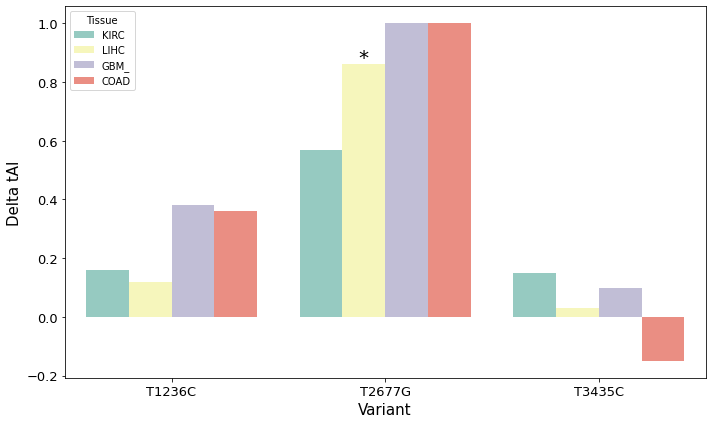

In [57]:
''' 
Plot tAI change for all examined tissues and for all three variants (sort of summary for the results of
each variant 
'''

measure = "tAI"
tai_tissues = pd.read_pickle("../Data/tAI_human_tissue_specific.pickle")# get human tAI weights- this is a nested dictionary, tAI changes dramatically among tissues
tissues_mdr1 = ["KIRC", "LIHC", "GBM_", "COAD"] #tissues in organs where MDR1 is naturally highly expressed

''' get parameters needed for each variant to plot the figure '''
params = {}
for var_num in [1,2,3]:
    params[var_num] = {}

    #basic data
    name = variant_info[var_num]["variant_name"]
    cds_pos = variant_info[var_num]["cds_position"]
    change_to = variant_info[var_num]["change_to"]
    codon_before = variant_info[var_num]["codon_before"]
    codon_after = variant_info[var_num]["codon_after"]

    for tissue in tissues_mdr1:

        #delta tai 
        measure_dict = tai_tissues[tissue]
        delta = np.round(measure_dict[codon_after] - measure_dict[codon_before], 2)

        #we also calculated a p-value in the notebook "p_vals_CUB_MDR1.ipynb"
        pvalue = np.round(pd.read_pickle(f"../Results/{measure}/delta_{measure}/{tissue}/pval_{cds_pos}.pickle"),2)

        #update params dict
        params[var_num][tissue] = {"name": name, "cds_pos": cds_pos, "delta": delta, "pvalue": pvalue}
    

''' move the parameters to a df with all the data needed for ploting '''
data_list = []
# Iterate over the "params" dictionary and extract values for each field
for key, inner_dict in params.items():
    for tissue, values in inner_dict.items():
        name = values['name']
        delta = values['delta']
        pvalue = values['pvalue']
        data_list.append({'name': name, 'delta': delta, 'pvalue': pvalue, 'tissue': tissue})
tai_df_for_plot = pd.DataFrame(data_list)

''' Plot '''
# Define the color palette
palette = sns.color_palette("Set3", len(tai_df_for_plot['tissue'].unique()))

# Create the bar plot
plt.figure(figsize=(10, 6))
ax = sns.barplot(data=tai_df_for_plot, x='name', y='delta', hue='tissue', palette=palette)

# Add significance marks based on the p-value column
for i, bar in enumerate(ax.patches):
    pvalue = tai_df_for_plot.loc[i, 'pvalue']
    if pvalue < 0.05:
        ax.annotate('*', xy=(bar.get_x() - 1 + bar.get_width() / 2, 0.85), ha='center', va='bottom', fontsize=20)

# Add labels and title
plt.xlabel('Variant', size = 15)
plt.ylabel('Delta tAI', size = 15)
#plt.title('Delta values for different variants and tissues', size = 15)
plt.xticks(size = 13)
plt.yticks(size = 13)

# Show the plot
plt.legend(title='Tissue', loc='upper left')
plt.tight_layout()

plt.savefig("../Figures/tAI/tAI_delta_all.png", bbox_inches = "tight", dpi=500)
plt.show();

